# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from sklearn.cluster import KMeans
from utils import get_disease_class
from sklearn.metrics import roc_auc_score
from lstm import KTokenizer, get_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
df = initial_pre(pd.read_csv(TRAIN_PATH))
len(df)

283086

In [5]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [6]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [7]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

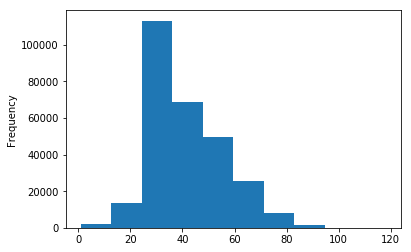

In [8]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

### Look up

In [9]:
tdf = initial_pre(pd.read_csv(TEST_PATH))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN


In [10]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [11]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

### Not in `tdf`

In [12]:
def filter_not_in_test(df, tdf, column):
    df = df.copy()
    in_tdf = set(tdf.loc[:, column])
    return df[df.loc[:, column].isin(in_tdf)].copy()

In [13]:
for column in tqdm_notebook(df.columns):
    if column not in {'revisit', 'anamnesis'}:
        df = filter_not_in_test(df, tdf, column)
        print('after', column, df.shape)
df.shape

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

after diag_code (280470, 9)
after diag (280470, 9)
after age (280456, 9)
after sex (280456, 9)
after state (278242, 9)
after allergies (274857, 9)
after checkup (274572, 9)



(274572, 9)

### Strings fuzzy matching

In [14]:
def group_column(df, tdf, column):
    df, tdf = df.copy(), tdf.copy()
    columnv = pd.concat([df[column], tdf[column]])
    cvc = columnv.value_counts()
    bins = []
    for s, c in tqdm_notebook(cvc.iteritems()):
        max_id, max_score = None, None
        for id_, bin_ in enumerate(bins):
            cur_score = fuzz.ratio(s, bin_[0])
            if max_score is None or cur_score > max_score:
                max_id = id_
                max_score = cur_score
        if max_id is not None and max_score > 50:
            bins[max_id].append(s)
        else:
            bins.append([s])
    remap_dict = {}
    for bin_ in bins:
        base = bin_[0]
        for v in bin_:
            remap_dict[v] = base
    df[column] = df[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    tdf[column] = tdf[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    return df, tdf

In [15]:
# SIMILAR_TEXT_COLUMNS = ['state', 'allergies', 'checkup']
# for column in tqdm_notebook(SIMILAR_TEXT_COLUMNS):
#     df, tdf = group_column(df, tdf, column)
# df.shape, tdf.shape

## Preprocess

### Only `anamnesis`

In [16]:
# def make_textclf_data(df, balance=False):
#     X, y = df.anamnesis.fillna(''), df.revisit
    
#     if balance:
#         n = y.value_counts().min()
#         y0, y1 = y[y == 0].sample(n), y[y == 1].sample(n)
#         X0, X1 = X[y0.index], X[y1.index]
#         X, y = pd.concat([X0, X1], axis=0).sample(frac=1), pd.concat([y0, y1], axis=0).sample(frac=1)
    
#     return X, y

### Features

In [17]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode

In [18]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sex_1d=None):
        self.sex_1d = sex_1d
        
        self._tok = None
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        if self.sex_1d:
            n = int((df.sex == 1).sum() / self.sex_1d)
            df1 = df[df.sex == 1]
            df2 = df[df.sex == 2].sample(n)
            df = pd.concat([df1, df2], axis=0)
    
        features = []
        
#         # diag_code
#         features.append(pd.DataFrame(list(df.diag_code.apply(parse_diag_code)), 
#                                      columns=['letter', 'code', 'subcode'],
#                                      dtype=object, index=df.index))
        # diag_code
        def to_str(x):
            if x is None:
                return ''
            else:
                return str(x)
        
        def pparse(x):
            l, c, s = x
            c = to_str(l) + to_str(c)
            if not c:
                c = None
            return (l, c)
        
        parts = list(df.diag_code \
                     .apply(parse_diag_code) \
                     .apply(pparse))
        features.append(pd.DataFrame(parts, 
                                     columns=['letter', 'code', 'subcode'][:2],
                                     dtype=object, index=df.index))
        
#         # +disease
#         features.append(pd.DataFrame(list(df.diag_code.apply(get_disease_class)),
#                                     columns=['disease'],
#                                     dtype=object, index=df.index))
        
        # diag
        features.append(df[['diag']])

        # age
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
        features.append(df[['age']])

        # sex
        features.append(df[['sex']])

        # state
        def state_map(s):
            if 'удовлетворительн' in str(s).lower():
                return True
            else:
                return False
            
        features.append(pd.DataFrame(df.state.apply(state_map).astype(int),
                                     columns=['state'],
                                     index=df.index, dtype=int))
        
        # allergies, checkup
        features.append(df[['allergies', 'checkup']])
        
#         # anamnesis
#         if self._tok is None:
#             self._tok = KTokenizer().fit(df.anamnesis)
#         features.append(pd.DataFrame(get_score(self._tok.transform(df.anamnesis)).astype(np.float64),
#                                      columns=['lstm_score'],
#                                      index=df.index))

        data = pd.concat(features, axis=1)
        data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [19]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,diag,age,sex,state,allergies,checkup
0,J,J6,Острый ларингофарингит,29.0,2,0,NaN,На жевательной поверхности 2.6- кариозная поло...
1,N,N76,Подострый и хронический вагинит,45.0,2,0,NaN,NaN
2,L,L23,"Аллергический контактный дерматит, причина не ...",63.0,2,0,NaN,NaN
3,N,N48,Баланопостит,43.0,2,0,не отягощен,NaN
4,Z,Z0,Общий медицинский осмотр,29.0,1,0,NaN,NaN


In [20]:
X.dtypes

letter        object
code          object
diag          object
age          float64
sex            int64
state          int64
allergies     object
checkup       object
dtype: object

In [21]:
y.dtype

dtype('int64')

## TT split

In [36]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.03)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((266334, 8), (8238, 8), (100000, 8))

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

In [37]:
import catboost as cb

In [38]:
# N_MODELS = 10

In [39]:
# models = [cb.CatBoostClassifier(depth=8, eval_metric='AUC', iterations=300) 
#           for _ in range(N_MODELS)]

In [40]:
# def get_stack_score(X):
#     return np.vstack((model.predict_proba(X)[:, 1] for model in models)).mean(axis=0)

In [ ]:
# for model in models:
#     model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

In [ ]:
model = cb.CatBoostClassifier(depth=8, eval_metric='AUC')
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_val, y_val), 
          plot=False);

0:	learn: 0.6596068	test: 0.6574113	best: 0.6574113 (0)	total: 271ms	remaining: 4m 30s
1:	learn: 0.6601614	test: 0.6576924	best: 0.6576924 (1)	total: 540ms	remaining: 4m 29s
2:	learn: 0.6607899	test: 0.6604547	best: 0.6604547 (2)	total: 809ms	remaining: 4m 28s
3:	learn: 0.6615850	test: 0.6613910	best: 0.6613910 (3)	total: 1.07s	remaining: 4m 26s
4:	learn: 0.6615036	test: 0.6618486	best: 0.6618486 (4)	total: 1.36s	remaining: 4m 31s
5:	learn: 0.6616047	test: 0.6623101	best: 0.6623101 (5)	total: 1.64s	remaining: 4m 31s
6:	learn: 0.6616962	test: 0.6622022	best: 0.6623101 (5)	total: 1.89s	remaining: 4m 27s
7:	learn: 0.6617236	test: 0.6619310	best: 0.6623101 (5)	total: 2.16s	remaining: 4m 27s
8:	learn: 0.6619118	test: 0.6615400	best: 0.6623101 (5)	total: 2.45s	remaining: 4m 29s
9:	learn: 0.6624929	test: 0.6624902	best: 0.6624902 (9)	total: 2.72s	remaining: 4m 29s
10:	learn: 0.6625552	test: 0.6627949	best: 0.6627949 (10)	total: 2.99s	remaining: 4m 28s
11:	learn: 0.6633251	test: 0.6632787	best

## Analysis

In [ ]:
roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

In [ ]:
model.get_params()

In [ ]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
draw_importance(X_train.columns, model.feature_importances_, save_path=None)

## Submission

In [ ]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = get_stack_score(X_test)
# sdf.head()

In [ ]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict_proba(X_test)[:, 1]
sdf.head()

In [ ]:
sdf.to_csv(SUBMISSION_PATH, index=False)